In [1]:
%matplotlib inline

import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from libs.libs import evaluation, compare_categorical, forward_selection, backward_selection, forward_backward_selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier

# 1. Load dataset

- **age**: The person's age in years  
- **sex**: The person's sex (1 = male, 0 = female)  
- **cp**: The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)  
- **trestbps**: The person's resting blood pressure (mm Hg on admission to the hospital)  
- **chol**: The person's cholesterol measurement in mg/dl  
- **fbs**: The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false)  
- **restecg**: Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing  probable or definite left ventricular hypertrophy by Estes' criteria)  
- **thalach**: The person's maximum heart rate achieved  
- **exang**: Exercise induced angina (1 = yes; 0 = no)  
- **oldpeak**: ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more here)  
- **slope**: the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)  
- **ca**: The number of major vessels (0-3)  
- ***thal**: A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)  
- **target**: Heart disease (0 = no, 1 = yes)  

In [2]:
# Load dataset
data_dir = "dataset/heart.csv"
dataset = pd.read_csv(data_dir)

# Ensure data types
numerical_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = ["exang", "fbs", "sex", "cp", "restecg", "slope", "ca", "thal"]
response = "target"

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB


Percentile of target == 1: 0.54%
Percentile of target == 0: 0.46%


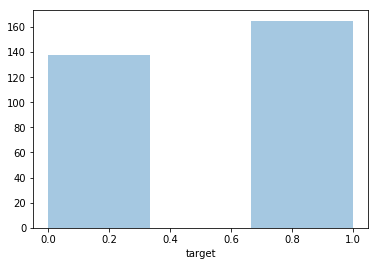

In [3]:
# Check response equality
sns.distplot(dataset[response], kde=False, bins=3)
precent_target_1 = len(np.where(dataset[response] == 1)[0]) / len(dataset[response])
precent_target_0 = len(np.where(dataset[response] == 0)[0]) / len(dataset[response])
print("Percentile of target == 1: {:.2f}%".format(precent_target_1))
print("Percentile of target == 0: {:.2f}%".format(precent_target_0))

### This dataset response is quite balanced (8% different), therefore, **accuracy** can be used measure model performance.

# 2. Split train test

In [4]:
# Train-test split
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# Predictors-response split
#train_set = pd.DataFrame(train_set.values, columns=train_set.columns)
y_train = train_set[response]
x_train = train_set.drop([response], axis=1)

#test_set = pd.DataFrame(test_set.values, columns=test_set.columns)
y_test = test_set[response]
x_test = test_set.drop([response], axis=1)

print("train_set: {}".format(train_set.shape))
print("test_set: {}".format(test_set.shape))

train_set: (242, 14)
test_set: (61, 14)


# 3. Get default accuracy

Default score
Train set accuracy: 86.36%
Validation set accuracy: 81.85%
R_squared: 44.91%


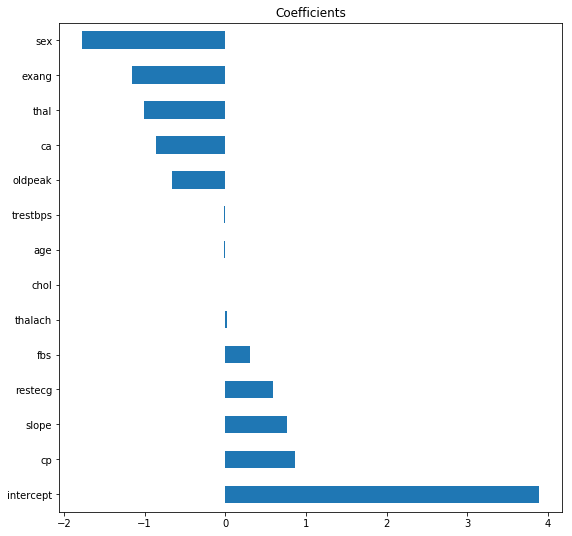

intercept    3.885450
cp           0.860352
slope        0.765203
restecg      0.592574
fbs          0.302947
thalach      0.018627
chol        -0.003751
age         -0.008836
trestbps    -0.017694
oldpeak     -0.660568
ca          -0.858269
thal        -1.008328
exang       -1.153436
sex         -1.772893
dtype: float64

In [5]:
# Fit logistic regression model to dataset without using regularization
logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=100000)

print("Default score")
evaluation(logis_reg, x_train, y_train)

# 4. Preprocessing data

## 4.1 Numerical

In [6]:
std_scaler = StandardScaler()

std_scaler.fit(x_train[numerical_features])

x_numerical = std_scaler.transform(x_train[numerical_features])
x_numerical = pd.DataFrame(x_numerical, columns=numerical_features, dtype="float64")

## 4.2 Categorical

In [7]:
encoder = OneHotEncoder(categories="auto", drop="first")

encoder.fit(x_train[categorical_features])

x_categorical = encoder.transform(x_train[categorical_features])

# Get feature names
feature_names = encoder.get_feature_names(categorical_features)
# Remove dropped columns
feature_names = [feature_name for feature_name in encoder.get_feature_names(categorical_features) if "_0" not in feature_name]

x_categorical = pd.DataFrame(x_categorical.toarray(), columns=feature_names, dtype="int8")

## 4.3 Merge

In [8]:
def create_polynomial(x, degree=2, interaction=False):
    assert degree > 1, "degree must be > 1, but get {}".format(degree)
    
    features_list = x.columns
    
    if interaction:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        new_x = poly.fit_transform(x)
        new_feature = poly.get_feature_names(features_list)
        
        polynomial = pd.DataFrame(new_x, columns=new_feature).drop(features_list, axis=1)
    else:
        polynomial = pd.DataFrame()
        new_x = []
        new_feature = []
        for feature in features_list:
            for d in range(2, degree + 1):
                new_x = np.power(x[feature], d)
                new_feature = feature + "^{}".format(d)

                polynomial[new_feature] = new_x
        
    return polynomial

def create_interaction(x):
    features_list = x.columns
    
    interaction = pd.DataFrame()
    for i in range(len(features_list) - 1):
        for j in range(i + 1, len(features_list)):
            feature_base = features_list[i]
            feature_target = features_list[j]
            
            new_x = x[feature_base] * x[feature_target]
            new_feature = feature_base + "_" + feature_target
            
            # feature that is all zero, shall not be added
            if np.sum(new_x) != 0:
                interaction[new_feature] = new_x
            
    return interaction

In [9]:
x_train_processed = pd.concat([x_numerical, x_categorical], axis=1)

# Create polynomial features
x_train_polynomial = create_polynomial(x_train_processed[numerical_features], degree=2, interaction=False)
x_train_polynomial = pd.concat([x_train_processed, x_train_polynomial], axis=1)

x_train_mix = create_polynomial(x_train_processed[numerical_features], degree=2, interaction=True)
x_train_mix = pd.concat([x_train_processed, x_train_mix], axis=1)

Using processed data
Train set accuracy: 88.02%
Validation set accuracy: 83.83%
R_squared: 51.59%


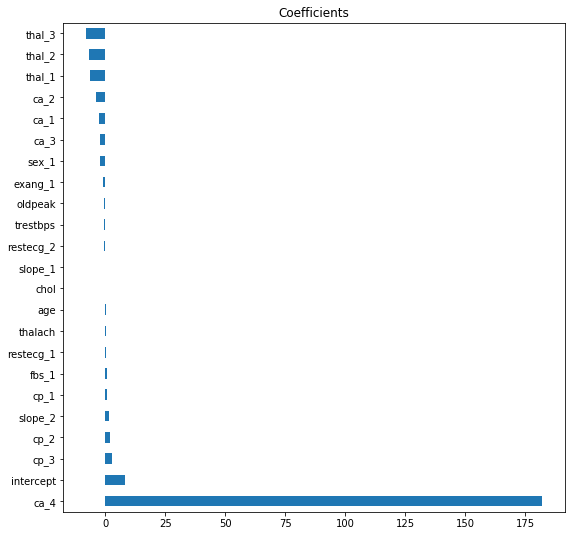

In [10]:
# Fit logistic regression model to dataset without using regularization
logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=100000)

print("Using processed data")
coef = evaluation(logis_reg, x_train_processed, y_train)

# 5. Check collinearity

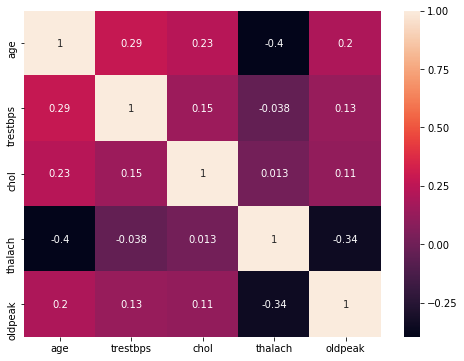

In [11]:
plt.subplots(figsize=(8, 6))
sns.heatmap(x_numerical.corr(), annot=True)
plt.show()

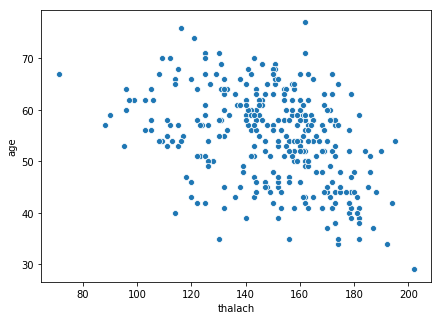

In [12]:
# -0.4 thalach correlate to age
plt.subplots(figsize=(7, 5))
sns.scatterplot(x="thalach", y="age", data=dataset[["age", "thalach"]])
plt.show()

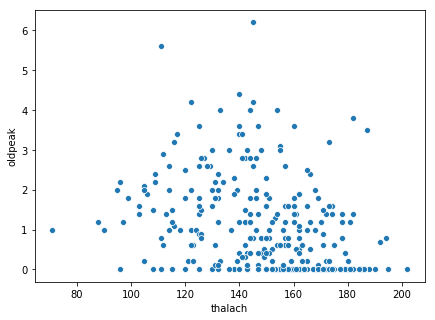

In [13]:
# -0.34 thalach correlate to oldpeak
plt.subplots(figsize=(7, 5))
sns.scatterplot(x="thalach", y="oldpeak", data=dataset[["oldpeak", "thalach"]])
plt.show()

### There is no collinearity in numerical predictors.

# 7. Feature selection

## 7.1 Using Tree's feature important

In [14]:
# Get best parameter for random forst model
param_grid = {"n_estimators": list(range(10, 100, 2))}
forest_clf = RandomForestClassifier(random_state=42)

clf = GridSearchCV(forest_clf, param_grid, cv=10, scoring="accuracy")
clf.fit(x_train, y_train)
print("Best param: {}".format(clf.best_params_))
print("Best score: {}".format(clf.best_score_))

Best param: {'n_estimators': 60}
Best score: 0.8305785123966942


/home/teakatz/.conda/envs/general/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


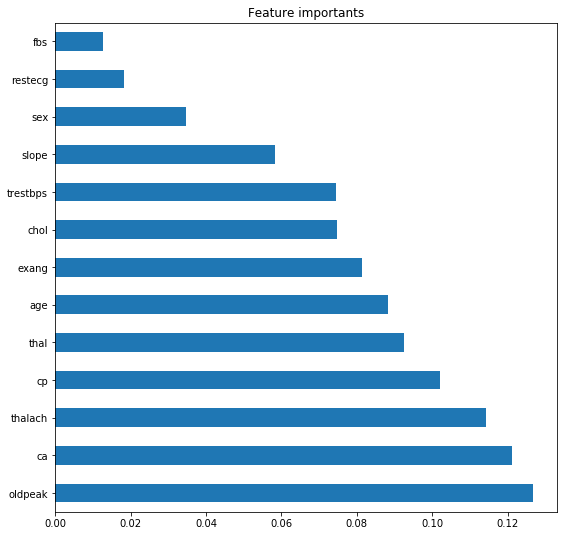

In [15]:
# Get important festures
feature_importants = pd.Series(clf.best_estimator_.feature_importances_, index=x_train.columns)
feature_importants_sorted = feature_importants.sort_values(ascending=False)
feature_importants_sorted.plot(kind="barh", figsize=(9, 9))
plt.title("Feature importants")
plt.show()

## 7.2 Using Subset selection

### 7.2.1 Best subset selection

### 7.2.2 Forward stepwise selection

['thal_2', 'oldpeak', 'ca_3', 'ca_1', 'oldpeak^2', 'restecg_2', 'ca_4', 'cp_2', 'restecg_1', 'cp_3', 'slope_1', 'sex_1', 'fbs_1', 'chol^2', 'thalach^2', 'slope_2', 'age^2', 'trestbps^2', 'trestbps', 'thal_1', 'ca_2', 'chol', 'age', 'thalach']
Train set accuracy: 89.67%
Validation set accuracy: 84.63%
R_squared: 58.27%


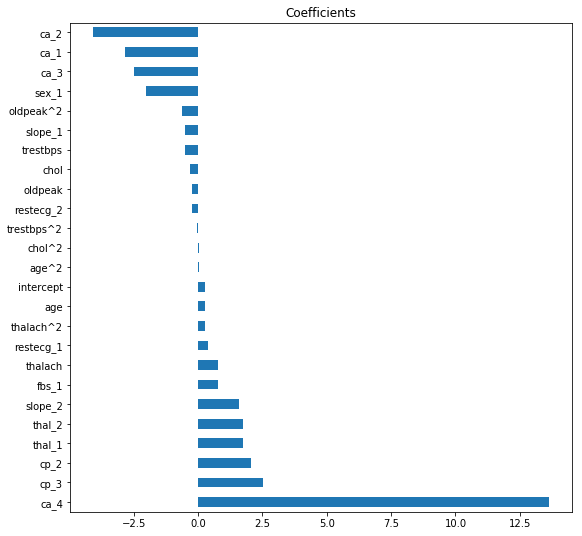

In [18]:
features = forward_selection(x_train_polynomial, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

['thal_2', 'oldpeak', 'ca_3', 'ca_1', 'oldpeak^2', 'chol^2', 'thalach^2', 'thal_3', 'thal_1', 'restecg_2', 'age^2', 'trestbps', 'ca_4', 'restecg_1', 'cp_2', 'ca_2', 'cp_3', 'sex_1', 'slope_2', 'slope_1', 'trestbps^2', 'age', 'chol', 'cp_1']
Train set accuracy: 90.08%
Validation set accuracy: 82.99%
R_squared: 59.94%


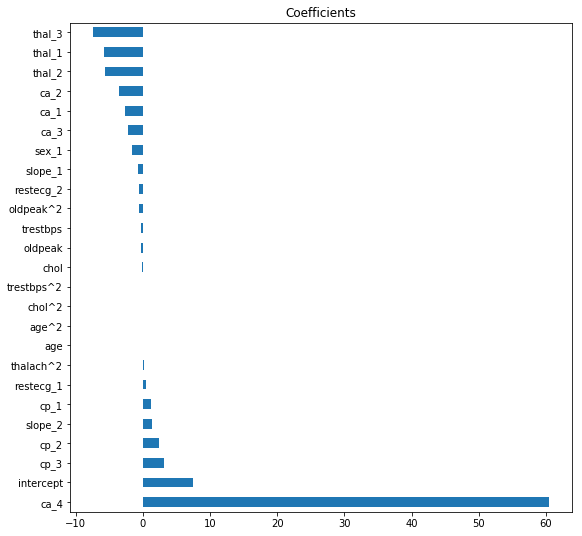

In [19]:
features = forward_selection(x_train_polynomial, y_train, keep_first=False)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

### 7.2.3 Backward stepwise selection

['trestbps', 'sex_1', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'slope_2', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_3', 'oldpeak^2']
Train set accuracy: 90.08%
Validation set accuracy: 87.16%
R_squared: 59.94%


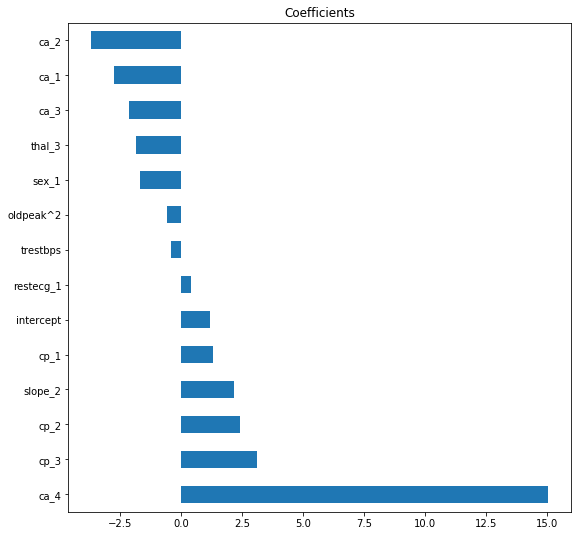

In [20]:
features = backward_selection(x_train_polynomial, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

['age', 'trestbps', 'thalach', 'sex_1', 'cp_2', 'cp_3', 'slope_2', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_1', 'thal_2', 'thalach^2', 'oldpeak^2']
Train set accuracy: 90.91%
Validation set accuracy: 85.88%
R_squared: 63.28%


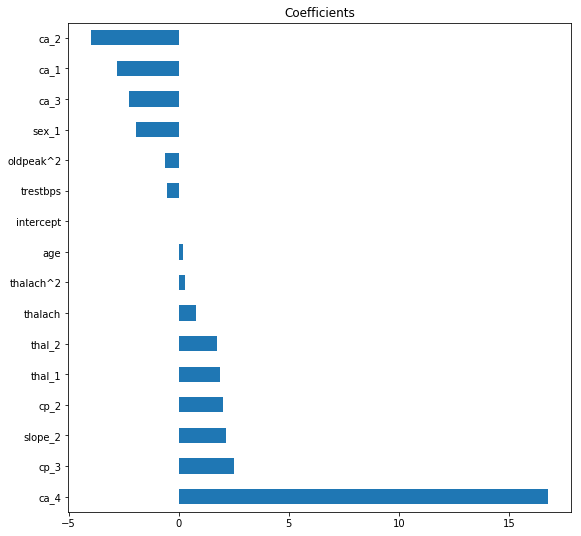

In [21]:
features = backward_selection(x_train_polynomial, y_train, keep_first=False)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

### 7.2.4 Hybrid appoaches

['thal_2', 'oldpeak', 'ca_3', 'ca_1', 'ca_4', 'cp_2', 'sex_1', 'chol^2', 'cp_3', 'ca_2', 'slope_1', 'age', 'restecg_1']
Train set accuracy: 90.08%
Validation set accuracy: 87.20%
R_squared: 59.94%


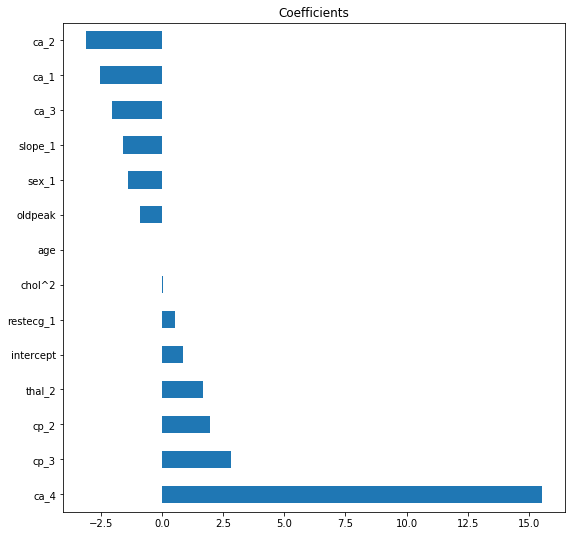

thal_2
match: 106/138 (76.81%)
invert_match: 32/138 (23.19%)
-----------------------
ca_3
match: 3/16 (18.75%)
invert_match: 13/16 (81.25%)
-----------------------
ca_1
match: 15/53 (28.30%)
invert_match: 38/53 (71.70%)
-----------------------
ca_4
match: 3/3 (100.00%)
invert_match: 0/3 (0.00%)
-----------------------
cp_2
match: 57/74 (77.03%)
invert_match: 17/74 (22.97%)
-----------------------
sex_1
match: 70/159 (44.03%)
invert_match: 89/159 (55.97%)
-----------------------
cp_3
match: 12/17 (70.59%)
invert_match: 5/17 (29.41%)
-----------------------
ca_2
match: 5/26 (19.23%)
invert_match: 21/26 (80.77%)
-----------------------
slope_1
match: 40/110 (36.36%)
invert_match: 70/110 (63.64%)
-----------------------
restecg_1
match: 77/126 (61.11%)
invert_match: 49/126 (38.89%)
-----------------------


In [28]:
features = forward_backward_selection(x_train_polynomial, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
_ = evaluation(logis_reg, x_train_polynomial[features], y_train)

for feature in features:
    if "_" in feature:
        print(feature)
        compare_categorical(x_train_polynomial[feature], y_train)
        print("-----------------------")

['thal_2', 'oldpeak', 'ca_3', 'ca_1', 'restecg_1', 'cp_2', 'restecg_2', 'ca_2', 'thal_1', 'cp_3', 'slope_1', 'sex_1', 'ca_4', 'fbs_1', 'thal_3', 'trestbps', 'cp_1', 'slope_2']
Train set accuracy: 90.08%
Validation set accuracy: 86.78%
R_squared: 59.94%


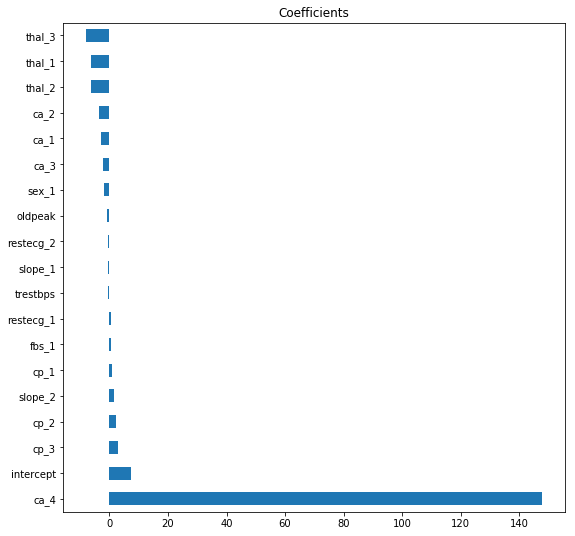

In [24]:
features = forward_backward_selection(x_train_processed, y_train, keep_first=True)
print(features)

logis_reg = LogisticRegression(solver="lbfgs", C=1e10, max_iter=1000)
coef_1 = evaluation(logis_reg, x_train_processed[features], y_train)

## 7.3 Using l1 regularization

In [29]:
# Get best parameter for random forst model
param_grid = {"C": list(range(1, 100, 1))}
logis_reg = LogisticRegression(penalty="l1" ,solver="saga", max_iter=100000)

clf = GridSearchCV(logis_reg, param_grid, cv=10, scoring="accuracy")
clf.fit(x_train_polynomial, y_train)
print("Best param: {}".format(clf.best_params_))
print("Best score: {}".format(clf.best_score_))

Best param: {'C': 2}
Best score: 0.8264462809917356


/home/teakatz/.conda/envs/general/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set accuracy: 88.02%
Validation set accuracy: 82.11%
R_squared: 51.59%


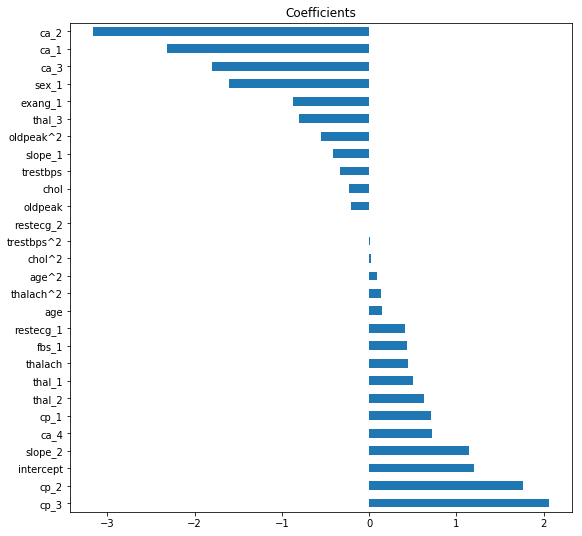

cp_3          2.064127
cp_2          1.766401
intercept     1.195871
slope_2       1.141768
ca_4          0.723275
cp_1          0.712959
thal_2        0.625298
thal_1        0.502802
thalach       0.448025
fbs_1         0.438535
restecg_1     0.411318
age           0.151976
thalach^2     0.133490
age^2         0.090017
chol^2        0.021470
trestbps^2    0.005377
restecg_2     0.000000
oldpeak      -0.204460
chol         -0.234326
trestbps     -0.339271
slope_1      -0.415979
oldpeak^2    -0.556995
thal_3       -0.809725
exang_1      -0.869884
sex_1        -1.603202
ca_3         -1.802620
ca_1         -2.320717
ca_2         -3.167115
dtype: float64

In [30]:
logis_reg = LogisticRegression(penalty="l1" ,solver="saga", C=4, max_iter=100000)
evaluation(logis_reg, x_train_polynomial, y_train)